In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import sys
import math
import logging
sys.path.append('../')

import dask_geopandas
# some data need to be converted to multi-type again
from utils.save_gdf_to_gdb import save_gdf_to_gdb
#from process.footprint_report import update_ln, update_poly, update_pt
from shapely import Polygon, MultiPolygon
from shapely import affinity

from its_logging.logger_config import logger
logger = logging.getLogger('process.footprint')

In [2]:
append_path = r"D:\WORK\wildfire\Interagency-Tracking-System\its\ITSGDB_backup\V2.0\appended.gdb"

In [3]:
enriched_polygons = gpd.read_file(append_path, driver='OpenFileGDB', layer='appended_poly')
enriched_points = gpd.read_file(append_path, driver='OpenFileGDB', layer='appended_point')
enriched_lines = gpd.read_file(append_path, driver='OpenFileGDB', layer='appended_line')

C:\Users\sky\.conda\envs\its_recode\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver OpenFileGDB does not support open option DRIVER
  return ogr_read(
C:\Users\sky\.conda\envs\its_recode\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(
C:\Users\sky\.conda\envs\its_recode\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver OpenFileGDB does not support open option DRIVER
  return ogr_read(
C:\Users\sky\.conda\envs\its_recode\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver OpenFileGDB does not support open option DRIVER
  return ogr_read(


In [4]:
years = ['2021', '2022', '2023']

In [5]:
def get_max_treatment(gdf):
    '''
    only use on specific agencies where treatment is reported with the same geometry
    '''
    max_idx = gdf.groupby(['TRMTID_USER', 'Year_txt'])['ACTIVITY_QUANTITY'].idxmax()
    return gdf.loc[max_idx]

In [6]:
def buffer_overreport_poly(row):
    if row.ACRE_RATIO <= 1:
        return row.geometry
    
    # scale up by centroid if type is polygon
    if isinstance(row.geometry, Polygon):
        return affinity.scale(row.geometry, xfact=np.sqrt(row.ACRE_RATIO), yfact=np.sqrt(row.ACRE_RATIO))
    # scale up by centroid of each polygon in multi-polygon
    else:
        out = []
        for geom in list(row.geometry.geoms):
            out.append(affinity.scale(geom, xfact=np.sqrt(row.ACRE_RATIO), yfact=np.sqrt(row.ACRE_RATIO)))
        return MultiPolygon(out)

In [7]:
def update_pt(enriched_points: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Update points with buffer calculations."""
    logger.info(f"      initial points count: {len(enriched_points)}")
    
    # Add BufferMeters field
    enriched_points['BufferMeters'] = None
    
    # Calculate buffer for AC units
    mask1 = (enriched_points['ACTIVITY_QUANTITY'].notna()) & (enriched_points['ACTIVITY_UOM'] == 'AC')
    logger.info(f"      points with valid ACTIVITY_QUANTITY and AC units: {mask1.sum()}")
    
    # Buffer point by their reported activity quantity 
    enriched_points.loc[mask1, 'BufferMeters'] = np.sqrt((enriched_points.loc[mask1, 'ACTIVITY_QUANTITY'] * 4046.86) / math.pi)
    
    # Filter for COUNTS_TO_MAS
    mask2 = (enriched_points['COUNTS_TO_MAS'] == 'YES') & (enriched_points['BufferMeters'].notna())
    logger.info(f"      points with COUNTS_TO_MAS='YES' and valid BufferMeters: {mask2.sum()}")
    
    selected_points = enriched_points[mask2].copy()

    selected_points = selected_points[selected_points['BufferMeters'] > 0]
    logger.info(f"      points with BufferMeters > 0: {len(selected_points)}")
    
    # Create buffers
    buffered_geoms = selected_points.apply(
        lambda row: row.geometry.buffer(row['BufferMeters']) if pd.notnull(row['BufferMeters']) else row.geometry,
        axis=1
    )
    
    # Create new GeoDataFrame with buffered geometries
    result = selected_points.copy()
    result.geometry = buffered_geoms
    logger.info(f"      final points count: {len(result)}")
    return result


def update_ln(enriched_lines: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Update lines with buffer calculations."""
    logger.info(f"      initial lines count: {len(enriched_lines)}")
        
    # Check for case differences
    if 'ACTIVITY_UOM' in enriched_lines.columns:
        unique_uom = enriched_lines['ACTIVITY_UOM'].unique()
        logger.info(f"      unique ACTIVITY_UOM values: {unique_uom}")
    
    # Add BufferMeters field
    enriched_lines['BufferMeters'] = None
    
    # Calculate line lengths
    line_lengths = enriched_lines.geometry.length
    logger.info(f"      lines with length > 0: {(line_lengths > 0).sum()}")
    
    # Modify conditions to be more lenient and check for case variations
    condition1 = enriched_lines['ACTIVITY_QUANTITY'].notna() if 'ACTIVITY_QUANTITY' in enriched_lines.columns else False
    logger.info(f"      lines with valid ACTIVITY_QUANTITY: {condition1.sum() if isinstance(condition1, pd.Series) else 0}")
    
    condition2 = enriched_lines['ACTIVITY_UOM'].str.upper() == 'AC' if 'ACTIVITY_UOM' in enriched_lines.columns else False
    logger.info(f"      lines with ACTIVITY_UOM = 'AC' (case insensitive): {condition2.sum() if isinstance(condition2, pd.Series) else 0}")
    
    # Check combined conditions
    mask1 = condition1 & condition2 & (line_lengths > 0)
    logger.info(f"      lines meeting all conditions: {mask1.sum() if isinstance(mask1, pd.Series) else 0}")
    
    if not isinstance(mask1, pd.Series) or mask1.sum() == 0:
        logger.warning("      no lines meet the filtering criteria. Please check if the required columns exist and contain expected values.")
        return enriched_lines[enriched_lines['geometry'].notna()].head(0)  # Return empty GeoDataFrame with same schema
    
    # Calculate buffer distances
    enriched_lines.loc[mask1, 'BufferMeters'] = (
        (enriched_lines.loc[mask1, 'ACTIVITY_QUANTITY'] * 4046.86) / 
        line_lengths[mask1] / 2
    )
    
    # Check COUNTS_TO_MAS condition
    condition3 =  (enriched_lines['COUNTS_TO_MAS'] == 'YES') & (enriched_lines['BufferMeters'].notna())
    logger.info(f"      lines with COUNTS_TO_MAS = 'YES': {condition3.sum() if isinstance(condition3, pd.Series) else 0}")
    
    condition4 = ~((enriched_lines['BufferMeters'] >= 200) & (enriched_lines['Source'] == 'CalTrans'))
    
    # Final filter
    mask2 = condition3 & condition4
    selected_lines = enriched_lines[mask2].copy()
    
    # caltrans activity is merged with treatment_id/geometry pair
    # safe to only take max to reduce dissolve process time
    caltrans = get_max_treatment(selected_lines[selected_lines.Source == 'CALTRANS'])
    selected_lines = pd.concat([selected_lines[selected_lines.Source != 'CALTRANS'], caltrans],ignore_index=True)
    
    
    # Create buffers
    buffered_geoms = selected_lines.apply(
        lambda row: row.geometry.buffer(row['BufferMeters'], cap_style='flat'),
        axis=1
    )
    
    # Create new GeoDataFrame with buffered geometries
    result = selected_lines.copy()
    result.geometry = buffered_geoms
    logger.info(f"      final lines count: {len(result)}")
    
    return result


def update_poly(enriched_polygons: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Update polygons with selection criteria."""
    logger.info(f"      initial polygons count: {len(enriched_polygons)}")

    mas_gdf = enriched_polygons[enriched_polygons['COUNTS_TO_MAS'] == 'YES']
    logger.info(f"      polygons with COUNTS_TO_MAS = 'YES': {mas_gdf.shape}")
    
    # inherited from arcpy version
    # from logger there seems to be no such anomoly
    treatment_gdf = enriched_polygons[enriched_polygons['TREATMENT_AREA'] < 100000]
    logger.info(f"      polygons with 'TREATMENT_AREA' < 100000: {treatment_gdf.shape}")
    
    mask = (
        (enriched_polygons['COUNTS_TO_MAS'] == 'YES') & 
        (enriched_polygons['TREATMENT_AREA'] < 100000)
    )

    final_gdf = enriched_polygons[mask].copy()
    
    
        

    # scale up by centroid of polygon geometry if reported acre is larger than geometry area
    final_gdf['ACRE_RATIO'] = final_gdf.ACTIVITY_QUANTITY* 4046.86/(final_gdf.geometry.area)
    final_gdf.geometry = final_gdf.apply(buffer_overreport_poly, axis = 1)
    final_gdf = final_gdf.drop('ACRE_RATIO', axis=1)
    
    
    logger.info(f"      final polygons: {final_gdf.shape}")
    
    return final_gdf

In [8]:
%%time
# Unit of Measure == Acres
# buffer data by activity quantity acre to the exact amount of acres
buffered_pt = update_pt(enriched_points)
buffered_ln = update_ln(enriched_lines)
buffered_poly = update_poly(enriched_polygons)

2025-05-21 10:30:46,784 INFO  [process.footprint     ]        initial points count: 14415
2025-05-21 10:30:46,787 INFO  [process.footprint     ]        points with valid ACTIVITY_QUANTITY and AC units: 13637
2025-05-21 10:30:46,791 INFO  [process.footprint     ]        points with COUNTS_TO_MAS='YES' and valid BufferMeters: 3116
2025-05-21 10:30:46,805 INFO  [process.footprint     ]        points with BufferMeters > 0: 2502
2025-05-21 10:30:46,878 INFO  [process.footprint     ]        final points count: 2502
2025-05-21 10:30:46,879 INFO  [process.footprint     ]        initial lines count: 103837
2025-05-21 10:30:46,889 INFO  [process.footprint     ]        unique ACTIVITY_UOM values: ['AC' 'MI' None 'EA' 'TON']
2025-05-21 10:30:47,298 INFO  [process.footprint     ]        lines with length > 0: 103837
2025-05-21 10:30:47,298 INFO  [process.footprint     ]        lines with valid ACTIVITY_QUANTITY: 103747
2025-05-21 10:30:47,320 INFO  [process.footprint     ]        lines with ACTIVIT

CPU times: total: 4.33 s
Wall time: 4.35 s


In [119]:
%%time
for y in years:
    poly_cur_y = buffered_poly[buffered_poly['Year_txt'] == y]
    ln_cur_y = buffered_ln[buffered_ln['Year_txt'] == y]
    pt_cur_y = buffered_pt[buffered_pt['Year_txt'] == y]
    
    # timber nonspatial should not follow the spatial operations below
    # take reported value at face value
    # append later to final result
    timber_cur_y = pt_cur_y[pt_cur_y.AGENCY == 'TIMBER']

    
    # concat together
    footprint_cur_y = pd.concat([poly_cur_y, ln_cur_y, pt_cur_y[pt_cur_y.AGENCY != 'TIMBER']], ignore_index=True)
    
    # drop unecessary fields, dissolve by treatment and take max activity quantity 
    # 05/08/2025 UPDATE: subject to change
    dissolved_cur_y = footprint_cur_y[['TRMTID_USER', 'ACTIVITY_QUANTITY', 'geometry']].dissolve('TRMTID_USER', aggfunc='max')
    
    # make valid would split a invalid polygon to multiple valid polygons and convert to MultiPolygon type
    dissolved_cur_y.geometry = dissolved_cur_y.make_valid()
    
    # simplified SIG Meatball&Speghetti function
    # use spatial join to rule out high overlapping
    ##############################################################################################################
    
    # create "meatballs" by taking the representative point of footprint polygons
    dissolved_point = dissolved_cur_y.copy()
    dissolved_point.geometry = dissolved_point.representative_point()
    
    # perform spatial join to find intersecting point/polygon
    joined_data = gpd.sjoin(dissolved_point, dissolved_cur_y, how='left', predicate='intersects').reset_index()
    
    # for polygon with multiple overlapping points, find the Treatment ID of those points whose Activity Quantity
    # is smaller than the polygon's Activity Quantity
    footprint_mask = joined_data[joined_data['ACTIVITY_QUANTITY_left'] < joined_data['ACTIVITY_QUANTITY_right']]['TRMTID_USER_left']
    
    # remove these non-qualifying treatments from footprint, essentially the same as taking max for overlapping
    footpring_gdf = dissolved_cur_y.reset_index()
    footpring_gdf = footpring_gdf[~footpring_gdf['TRMTID_USER'].isin(footprint_mask)]
    
    ##############################################################################################################


CPU times: total: 1min 30s
Wall time: 1min 30s


In [122]:
footpring_gdf.ACTIVITY_QUANTITY.sum() + timber_cur_y.ACTIVITY_QUANTITY.sum()

np.float64(698130.6024464676)

In [87]:
test_timber = timber_cur_y[['TRMTID_USER', 'ACTIVITY_QUANTITY', 'geometry']].set_index('TRMTID_USER')

In [88]:
dissolved_point = test_timber.copy()
dissolved_point.geometry = dissolved_point.representative_point()

In [89]:
# Perform spatial join
joined_data = gpd.sjoin(dissolved_point, test_timber, how='left', predicate='intersects')


In [90]:
max_footprint = joined_data.reset_index()

In [97]:
test_mid = max_footprint[max_footprint['TRMTID_USER_left'] != max_footprint['TRMTID_USER_right']]

In [100]:
test_mid

,TRMTID_USER_left,ACTIVITY_QUANTITY_left,geometry,TRMTID_USER_right,ACTIVITY_QUANTITY_right
1,TI-2,13169.946525,POINT (-294794.243 -53301.196),TI-70,34337.536889
2,TI-8,375.000000,POINT (-286320.171 -38298.821),TI-61,30646.452164
8,TI-22,1000.000000,POINT (-306999.994 -38983.172),TI-19,95578.777497
10,TI-25,500.000000,POINT (-299529.723 -40247.824),TI-19,95578.777497
17,TI-49,142.660678,POINT (-298644.626 -51202.982),TI-70,34337.536889
20,TI-52,2918.398095,POINT (-297394.655 -41806.259),TI-61,30646.452164
22,TI-58,1525.818568,POINT (-293083.987 -45224.923),TI-70,34337.536889
25,TI-64,2298.548819,POINT (-297551.933 -46312.175),TI-70,34337.536889


In [104]:
test_mask = 

<Axes: >

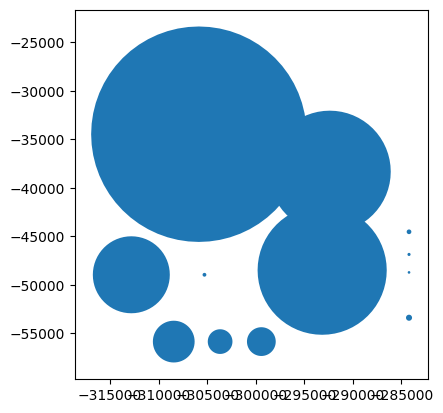

In [108]:
timber_cur_y[~timber_cur_y['TRMTID_USER'].isin(test_mask)].plot()

<Axes: >

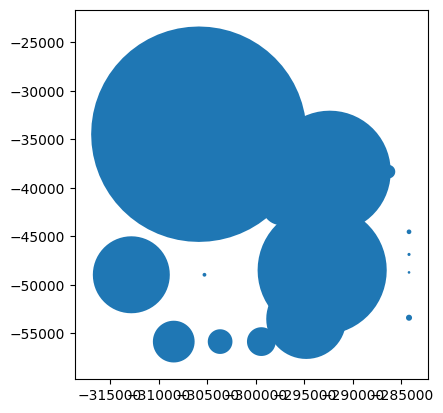

In [109]:
timber_cur_y.plot()

In [94]:
test_out = max_footprint[max_footprint['ACTIVITY_QUANTITY_left'] >= max_footprint['ACTIVITY_QUANTITY_right']].groupby('TRMTID_USER_right').max('ACTIVITY_QUANTITY_right')

In [95]:
len(test_out)

20

In [96]:
len(test_timber)

20

In [11]:
def get_NOP_recur(gdf1, gdf2):
    intersection = gpd.overlay(gdf1, gdf2, how='intersection')
    difference = gpd.overlay(gdf1, gdf2, how='difference')
    
    temp_nop = pd.concat([intersection, difference])
    if len(temp_nop) <= 1:
        return [gdf1]
    else:
        return [get_NOP_recur(temp_nop.iloc[[i]], 
                              pd.concat([temp_nop.iloc[0:i],temp_nop.iloc[i+1:]])) for i in range(len(temp_nop))]

In [12]:

def get_NOP(gdf):
    out = []
    for i in range(len(gdf)):
        nop_cur = get_NOP_recur(gdf.iloc[[i]], pd.concat([gdf.iloc[0:i],gdf.iloc[i+1:]]))
        nop_cur = pd.concat(flatten(nop_cur)).drop_duplicates('geometry')
        nop_cur = nop_cur[~np.isclose(nop_cur.area, 0)]
        
        out.append(nop_cur)
        
    return pd.concat(flatten(out)).drop_duplicates('geometry')

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
import dask_geopandas
# some data need to be converted to multi-type again
from utils.save_gdf_to_gdb import save_gdf_to_gdb

In [ ]:
%%time
from multiprocessing import Pool

def process_nop(i):
    nop_cur = get_NOP_recur(dissolved_cur_y.iloc[[i]], pd.concat([dissolved_cur_y.iloc[0:i],dissolved_cur_y.iloc[i+1:]]))
    nop_cur = pd.concat(flatten(nop_cur)).drop_duplicates('geometry')
    nop_cur = nop_cur[~np.isclose(nop_cur.area, 0)]
    return nop_cur


if __name__ == '__main__':
    pool = Pool(processes=8)                      
    pool.map(process_nop, range(len(dissolved_cur_y)))

In [213]:
%%time
out = get_NOP(dissolved_cur_y)

KeyboardInterrupt: 

In [75]:
from matplotlib import pyplot as plt

<Axes: >

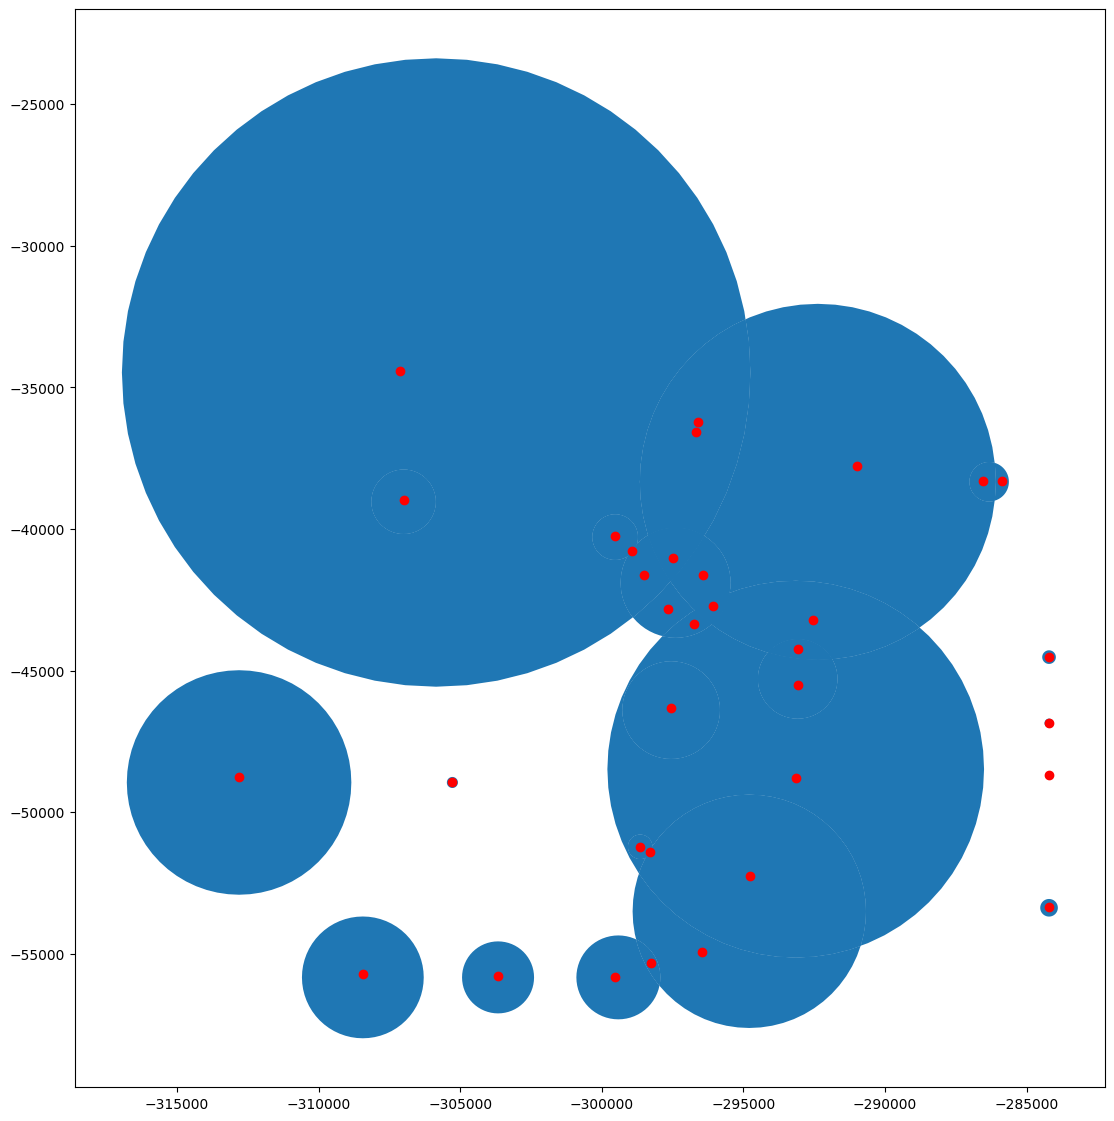

In [212]:
f, ax = plt.subplots()
f.set_size_inches(14, 14)
out.plot(ax=ax)
out.representative_point().drop_duplicates().plot(ax=ax,c='red',)

In [195]:
len(pd.concat(flatten(out)).representative_point().drop_duplicates())

34

In [ ]:
# line buffer simplification does not have enough spatial resolution for this sensitive probability calculation

In [243]:
buffered_poly[buffered_poly.TRMTID_USER == '{87AB0448-8E28-488F-A19A-3BF7C86336AA}-CNRA']

,PROJECTID_USER,AGENCY,ORG_ADMIN_p,PROJECT_CONTACT,PROJECT_EMAIL,ADMINISTERING_ORG,PROJECT_NAME,PROJECT_STATUS,PROJECT_START,PROJECT_END,...,SHAPE_Area,index_right,FIPS,STATE,ST_ABBREV,SQMI,POPULATION,Shape_Length_1,Shape_Area_1,geometry
12653,{312AFFED-EF63-47C9-82C8-363FD8AAA6FF}-CNRA,CNRA,CALFIRE,CAL FIRE Data Contact,FRAPdatacontact@fire.ca.gov,CALFIRE,High Sierra Front Country Fuel Breaks Project,COMPLETE,2022-03-01 00:00:00+00:00,2023-12-05 00:00:00+00:00,...,NaN,0.0,06,California,CA,158144.83,39648525,5.682717e+06,4.095942e+11,"MULTIPOLYGON (((63419.474 -101968.354, 63428.3..."
12655,{312AFFED-EF63-47C9-82C8-363FD8AAA6FF}-CNRA,CNRA,CALFIRE,CAL FIRE Data Contact,FRAPdatacontact@fire.ca.gov,CALFIRE,High Sierra Front Country Fuel Breaks Project,COMPLETE,2022-03-01 00:00:00+00:00,2023-12-05 00:00:00+00:00,...,NaN,0.0,06,California,CA,158144.83,39648525,5.682717e+06,4.095942e+11,"MULTIPOLYGON (((63419.474 -101968.354, 63428.3..."


In [244]:
max(buffered_ln.ACTIVITY_QUANTITY*4046.86/buffered_ln.geometry.area)

1.461965217156889

In [245]:
min(buffered_ln.ACTIVITY_QUANTITY*4046.86/buffered_ln.geometry.area)

0.9970375098538626

In [217]:
dissolved_cur_y = dissolved_cur_y.reset_index()

In [219]:
%%time
dissolved_cur_y['geom'] = dissolved_cur_y.geometry

gdf = gpd.sjoin(dissolved_cur_y, dissolved_cur_y,
                how="inner",
                predicate="intersects",
                lsuffix="left",
                rsuffix="right")

gdf = gdf[gdf.index != gdf.index_right]
gdf['intersection_geom'] = gdf['geom_left'].intersection(gdf['geom_right'])
gdf['intersection'] = gdf.apply(
    lambda r: f"{r['TRMTID_USER_left']} & {r['TRMTID_USER_right']}", axis=1)

CPU times: total: 11.6 s
Wall time: 11.6 s


In [220]:
gdf.set_geometry('intersection_geom', drop=True, inplace=True)

C:\Users\sky\AppData\Local\Temp\ipykernel_1265932\184717377.py:1: FutureWarning: The `drop` keyword argument is deprecated and in future the only supported behaviour will match drop=False. To silence this warning and adopt the future behaviour, stop providing `drop` as a keyword to `set_geometry`. To replicate the `drop=True` behaviour you should update your code to
`geo_col_name = gdf.active_geometry_name; gdf.set_geometry(new_geo_col).drop(columns=geo_col_name).rename_geometry(geo_col_name)`.
  gdf.set_geometry('intersection_geom', drop=True, inplace=True)


In [299]:
interestion_gdf = gdf[['ACTIVITY_QUANTITY_left', 'ACTIVITY_QUANTITY_right', 'TRMTID_USER_left', 'geometry']]

In [327]:
gdf['prob_left'] = gdf.ACTIVITY_QUANTITY_left*4046.86/gdf.geom_left.area
gdf.loc[gdf['prob_left'] > 1, 'prob_left'] = 1
gdf['prob_right'] = gdf.ACTIVITY_QUANTITY_right*4046.86/gdf.geom_right.area
gdf.loc[gdf['prob_right'] > 1, 'prob_right'] = 1

In [300]:
# tolerence for geometry smoothing on intersection results to keep result geom type be multipolygon/polygon
tolerence = 1e-8

In [301]:
diff_buffer = interestion_gdf.buffer(tolerence)

In [302]:
diff_buffer_gdf = interestion_gdf.copy()
diff_buffer_gdf.geometry = diff_buffer

In [285]:
%%time
diff_gdf = dissolved_cur_y.overlay(diff_buffer_gdf, how='difference', keep_geom_type=False)
#diff_gdf.geometry = diff_gdf.buffer(tolerence)

CPU times: total: 2min 32s
Wall time: 2min 32s


In [286]:
sum(diff_gdf.geometry.area)

3032954594.3421783

In [271]:
sum(dissolved_cur_y.geometry.area)

3954377595.371912

In [163]:
sum(diff_gdf.geometry.area) + sum(interestion_gdf.geometry.area)

4015915939.452771

In [162]:
sum(interestion_gdf.geometry.area)

982945942.8896587

In [155]:
interesection_all = interestion_gdf.dissolve()

401641724.05769753

In [165]:
sum(diff_gdf.geometry.area) + sum(interesection_all.area)

3434611720.6208105

In [287]:
diff_gdf['prob_self'] = diff_gdf.geometry.area/diff_gdf.geom.area

In [288]:
diff_gdf.loc[diff_gdf['prob_self']>1, 'prob_self'] = 1

In [291]:
diff_gdf

,TRMTID_USER,geometry,ACTIVITY_QUANTITY,geom,prob_self
0,01-DN-101-DN-NOR-WUI,"MULTIPOLYGON (((-342291.412 406063.922, -34229...",32.40,"MULTIPOLYGON (((-342583.596 406960.852, -34258...",0.809056
1,01-DN-169-DN-NOR-WUI,"MULTIPOLYGON (((-336986.135 396726.867, -33698...",8.50,"POLYGON ((-337005.425 396726.106, -336987.306 ...",0.999887
2,01-DN-197-DN-NOR-WUI,"POLYGON ((-339575.871 428285.734, -339559.487 ...",5.86,"POLYGON ((-339603.722 428203.383, -339600.298 ...",0.999945
3,01-DN-199-DN-NOR-NON,"MULTIPOLYGON (((-345198.562 428197.653, -34519...",10.00,"POLYGON ((-345202.203 428196.454, -345202.18 4...",0.999964
4,01-HUM-036-HUM-NOR-WUI,"MULTIPOLYGON (((-351052.646 289067.603, -35105...",45.00,"POLYGON ((-351049.545 289066.052, -351065.559 ...",0.999969
...,...,...,...,...,...
6000,{FF598D57-7CFF-4FB8-800C-30CC05762B0F}-CNRA,"POLYGON ((113262.243 -408589.435, 113257.71 -4...",20.00,"POLYGON ((113262.243 -408589.435, 113257.71 -4...",1.000000
6001,{FFBBE1BD-76E2-4C81-A648-836A7A5BE12B}-CNRA,"MULTIPOLYGON (((136377.394 -255147.671, 136376...",1.00,"MULTIPOLYGON (((136377.394 -255147.671, 136376...",1.000000
6002,{FFCAC627-1969-4812-99E7-CF25F1D98D4A}-CNRA,"MULTIPOLYGON (((-62945.288 105650.715, -62944....",10.00,"POLYGON ((-62943.677 105739.715, -62944.36 105...",0.031704
6003,{FFCE3441-F814-4C8C-B2A5-4273E9B64873}-CNRA,"POLYGON ((83235.69 -138825.181, 83253.236 -138...",37.00,"POLYGON ((83235.69 -138825.181, 83253.236 -138...",1.000000


In [280]:
intersection_gdf

,TRMTID_USER_1,ACTIVITY_QUANTITY_1,TRMTID_USER_2,ACTIVITY_QUANTITY_2,geometry
1,01-DN-101-DN-NOR-WUI,32.4,01-DN-169-DN-NOR-WUI,8.50,"POLYGON ((-337035.564 396722.601, -337034.107 ..."
2,01-DN-101-DN-NOR-WUI,32.4,01-DN-197-DN-NOR-WUI,5.86,"POLYGON ((-343862.16 436805.722, -343862.805 4..."
3,01-DN-101-DN-NOR-WUI,32.4,01-DN-199-DN-NOR-NON,10.00,"POLYGON ((-345196.93 428198.472, -345197.501 4..."
4,01-DN-101-DN-NOR-WUI,32.4,01-HUM-101-HUM-NOR-NON,88.22,"MULTIPOLYGON (((-337573.844 390254.38, -337573..."
5,01-DN-101-DN-NOR-WUI,32.4,{7A8F6B6C-4B62-419C-96B2-322264EBCD8D}-CNRA,225.00,"MULTIPOLYGON (((-342584.01 406966.193, -342591..."
...,...,...,...,...,...
19155,{FE96B4DC-B6EA-4011-A06B-DF502E15B1A0}-CNRA,3.8,{EF7C0DBE-3D73-47A0-948E-4BFC24D0CE94}-CNRA,6.30,"POLYGON ((324754.869 -538602.318, 324758.391 -..."
19156,{FE96B4DC-B6EA-4011-A06B-DF502E15B1A0}-CNRA,3.8,{F8234F64-8357-4AA0-A906-D9772D8A99A8}-CNRA,8.60,"POLYGON ((324748.788 -538617.841, 324748.431 -..."
19157,{FE96B4DC-B6EA-4011-A06B-DF502E15B1A0}-CNRA,3.8,{FC1D44EC-E5E8-4BB9-8197-A8C57D6B9688}-CNRA,1.00,"POLYGON ((324756.902 -538599.787, 324761.72 -5..."
19160,{FED24A6D-4C52-41C9-A42E-F9C8FE0A0E43}-CNRA,21.0,{1CECCD06-ABEE-4FBF-B7B0-A5A240E75A19}-CNRA,21.00,"MULTIPOLYGON (((-205565.255 331583.555, -20557..."


In [293]:
dissolved_cur_y['p_ACTIVITY'] = dissolved_cur_y.ACTIVITY_QUANTITY*4046.86/dissolved_cur_y.geometry.area

In [294]:
# enforce p <= 1 on inaccurate buffered polygons (mostly from line data)
dissolved_cur_y.loc[dissolved_cur_y['p_ACTIVITY'] > 1, 'p_ACTIVITY'] = 1

In [ ]:
dissolved_cur_y['FOOTPRINT_ACRES'] = dissolved_cur_y.apply()

In [304]:
test_id = "01-DN-101-DN-NOR-WUI"

In [329]:
intersecting_areas = gdf[gdf['TRMTID_USER_left'] == test_id]

In [321]:
intersecting_areas['TRMTID_USER_right']

,TRMTID_USER_left,geometry,ACTIVITY_QUANTITY_left,geom_left,index_right,TRMTID_USER_right,ACTIVITY_QUANTITY_right,geom_right,intersection,prob_left
0,01-DN-101-DN-NOR-WUI,"MULTIPOLYGON (((-337574.449 390254.641, -33757...",32.4,"MULTIPOLYGON (((-342583.596 406960.852, -34258...",6,01-HUM-101-HUM-NOR-NON,88.22,"MULTIPOLYGON (((-322811.141 227232.756, -32281...",01-DN-101-DN-NOR-WUI & 01-HUM-101-HUM-NOR-NON,4.375942e-08
0,01-DN-101-DN-NOR-WUI,"POLYGON ((-337035.564 396722.601, -337034.107 ...",32.4,"MULTIPOLYGON (((-342583.596 406960.852, -34258...",1,01-DN-169-DN-NOR-WUI,8.50,"POLYGON ((-337005.425 396726.106, -336987.306 ...",01-DN-101-DN-NOR-WUI & 01-DN-169-DN-NOR-WUI,2.956419e-05
0,01-DN-101-DN-NOR-WUI,"MULTIPOLYGON (((-342584.01 406966.193, -342591...",32.4,"MULTIPOLYGON (((-342583.596 406960.852, -34258...",5311,{7A8F6B6C-4B62-419C-96B2-322264EBCD8D}-CNRA,225.00,"MULTIPOLYGON (((-338572.881 372842.016, -33855...",01-DN-101-DN-NOR-WUI & {7A8F6B6C-4B62-419C-96B...,1.909002e-01
0,01-DN-101-DN-NOR-WUI,"POLYGON ((-343862.16 436805.722, -343862.805 4...",32.4,"MULTIPOLYGON (((-342583.596 406960.852, -34258...",2,01-DN-197-DN-NOR-WUI,5.86,"POLYGON ((-339603.722 428203.383, -339600.298 ...",01-DN-101-DN-NOR-WUI & 01-DN-197-DN-NOR-WUI,6.615047e-06
0,01-DN-101-DN-NOR-WUI,"POLYGON ((-345196.93 428198.472, -345197.501 4...",32.4,"MULTIPOLYGON (((-342583.596 406960.852, -34258...",3,01-DN-199-DN-NOR-NON,10.00,"POLYGON ((-345202.203 428196.454, -345202.18 4...",01-DN-101-DN-NOR-WUI & 01-DN-199-DN-NOR-NON,7.812525e-06


In [315]:
p_activity = dissolved_cur_y[dissolved_cur_y['TRMTID_USER'].isin(intersecting_areas['TRMTID_USER_right'])].p_ACTIVITY

In [320]:
p_treatment = 1 - sum(1-p_activity)

In [ ]:
def get_footprint_acre(row):
    intersecting_areas = gdf[gdf['TRMTID_USER_left'] == row['TRMTID_USER']]
    p_activity = dissolved_cur_y[dissolved_cur_y['TRMTID_USER'] in intersecting_areas['TRMTID_USER_right']].p_ACTIVITY
    
    p_treatment = 1 - sum(1-p_activity)

<Axes: >

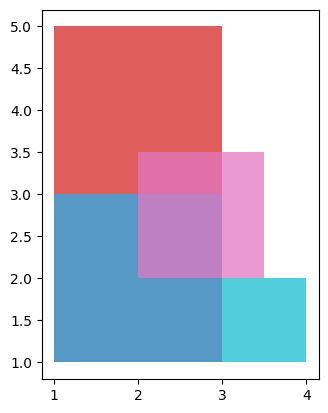

In [332]:
polygons = [
    Polygon([[1, 1], [1, 3], [3, 3], [3, 1], [1, 1]]),
    Polygon([[1, 3], [1, 5], [3, 5], [3, 3], [1, 3]]),
    Polygon([[2, 2], [2, 3.5], [3.5, 3.5], [3.5, 2], [2, 2]]),
    Polygon([[3, 1], [3, 2], [4, 2], [4, 1], [3, 1]]),
]
gdf = gpd.GeoDataFrame(data={'A': list('ABCD')}, geometry=polygons)
gdf.plot(column='A', alpha=0.75)

In [333]:
non_overlapping = []
for n, p in enumerate(polygons[:-1], 1):
    if not any(p.overlaps(g) for g in polygons[n:]):
        non_overlapping.append(p)

In [334]:
non_overlapping

[<POLYGON ((2 2, 2 3.5, 3.5 3.5, 3.5 2, 2 2))>]

In [338]:
region_id = '04'
usfs_input_gdb_path = r'D:\WORK\wildfire\Interagency-Tracking-System\V2.0\FACTS_V2.0\Actv_CommonAttribute_PL_Region{}.gdb'.format(region_id)
        

In [339]:
gpd.list_layers(usfs_input_gdb_path)

,name,geometry_type
0,Actv_CommonAttribute_PL,MultiPolygon
